In [4]:

import os
import csv
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Sample Image Figerprint Matching

In [5]:

class FingerprintRecognizer:
    def __init__(self, real_images_dir):
        self.real_images_dir = real_images_dir
        self.sift = cv2.SIFT_create()
        self.flann = cv2.FlannBasedMatcher({"algorithm": 1, "trees": 10}, {})

    def preprocess_image(self, image):
        return image

    def crop_fingerprint(self, image, keypoints):
        x_coords, y_coords = zip(*[kp.pt for kp in keypoints])
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))
        return image[y_min:y_max, x_min:x_max]

    def match_fingerprints(self, sample_image):
        best_score = 0
        best_filename = None
        best_image = None
        best_keypoints_sample = None
        best_keypoints_fingerprint = None
        best_match_points = None

        sample_image = self.preprocess_image(sample_image)
        keypoints_sample, descriptors_sample = self.sift.detectAndCompute(sample_image, None)

        if keypoints_sample is None:
            print("Keypoint detection failed for the sample image.")
            return None, None, None

        for filename in tqdm(os.listdir(self.real_images_dir), desc="Processing images"):
            fingerprint_path = os.path.join(self.real_images_dir, filename)
            fingerprint_image = cv2.imread(fingerprint_path)

            if fingerprint_image is None:
                print(f"Error loading: {fingerprint_path}")
                continue

            fingerprint_image = self.preprocess_image(fingerprint_image)
            keypoints_fingerprint, descriptors_fingerprint = self.sift.detectAndCompute(fingerprint_image, None)

            if keypoints_fingerprint is None:
                print(f"Keypoint detection failed for {fingerprint_path}")
                continue

            matches = self.flann.knnMatch(descriptors_sample, descriptors_fingerprint, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
            score = len(good_matches) / max(len(keypoints_sample), len(keypoints_fingerprint)) * 100

            if score > best_score:
                best_score = score
                best_filename = filename
                best_image = fingerprint_image
                best_keypoints_sample, best_keypoints_fingerprint, best_match_points = keypoints_sample, keypoints_fingerprint, good_matches

        return best_filename, best_score, best_match_points

    def visualize_match(self, sample_image, best_match_points, best_image, best_keypoints_sample, best_keypoints_fingerprint):
        if best_match_points:
            cropped_sample = self.crop_fingerprint(sample_image, best_keypoints_sample)
            cropped_best = self.crop_fingerprint(best_image, best_keypoints_fingerprint)

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(cv2.cvtColor(cv2.drawMatches(cropped_sample, best_keypoints_sample, cropped_best, best_keypoints_fingerprint, best_match_points, None), cv2.COLOR_BGR2RGB))
            axs[0].set_title("Matching Keypoints")
            axs[0].axis("off")

            axs[1].imshow(cropped_best)
            axs[1].scatter(*zip(*[kp.pt for kp in best_keypoints_fingerprint]), s=10, c='r', marker='o')
            axs[1].set_title("Best Match")
            axs[1].axis("off")

            plt.show()

    def save_match(self, best_image, filename):
        cv2.imwrite(filename, best_image)



Processing images: 100%|█████████████████████████████| 6000/6000 [00:30<00:00, 199.93it/s]


Best match: 342__M_Right_ring_finger.BMP
Best score: 79.31


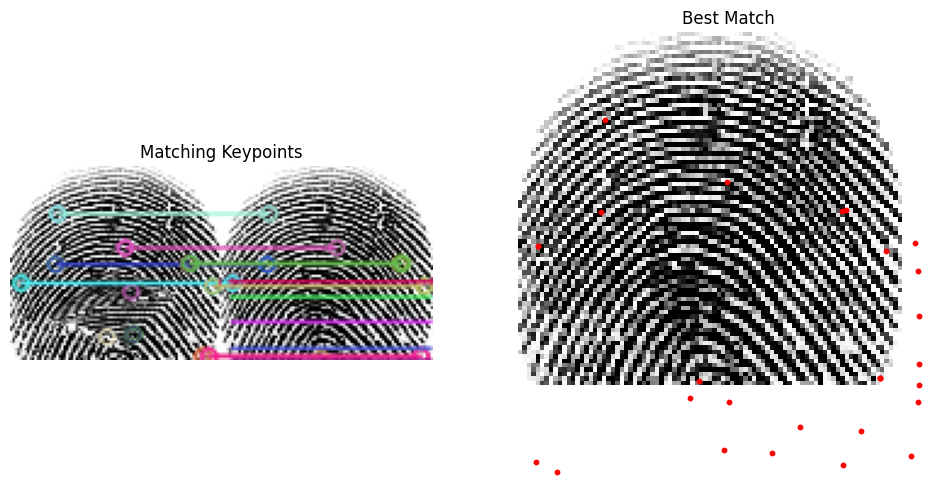

In [6]:
if __name__ == "__main__":
    real_images_dir = "SOCOFing/Real"
    sample_path = "SOCOFing/Altered/342__M_Right_ring_finger_Zcut.BMP"
    sample_image = cv2.imread(sample_path)

    recognizer = FingerprintRecognizer(real_images_dir)
    best_filename, best_score, best_match_points = recognizer.match_fingerprints(sample_image)

    if best_filename:
        print(f"Best match: {best_filename}")
        print(f"Best score: {best_score:.2f}")
        best_image = cv2.imread(os.path.join(real_images_dir, best_filename))
        keypoints_sample, _ = recognizer.sift.detectAndCompute(sample_image, None)
        keypoints_fingerprint, _ = recognizer.sift.detectAndCompute(best_image, None)
        recognizer.visualize_match(sample_image, best_match_points, best_image, keypoints_sample, keypoints_fingerprint)
        recognizer.save_match(best_image, "best_match_result.jpg")
    else:
        print("No match found.")


# 20 Images Figerprint Matching With Confidence level

In [7]:
import os
import cv2
import numpy as np
import csv
from tqdm import tqdm

class FingerprintRecognizer:
    def __init__(self, real_images_dir):
        self.real_images_dir = real_images_dir
        self.sift = cv2.SIFT_create()
        self.flann = cv2.FlannBasedMatcher({"algorithm": 1, "trees": 10}, {})

    def preprocess_image(self, image):
        return image

    def crop_fingerprint(self, image, keypoints):
        x_coords, y_coords = zip(*[kp.pt for kp in keypoints])
        x_min, x_max = int(min(x_coords)), int(max(x_coords))
        y_min, y_max = int(min(y_coords)), int(max(y_coords))
        return image[y_min:y_max, x_min:x_max]

    def match_fingerprints(self, sample_image, real_image):
        sample_image = self.preprocess_image(sample_image)
        real_image = self.preprocess_image(real_image)
        
        keypoints_sample, descriptors_sample = self.sift.detectAndCompute(sample_image, None)
        keypoints_real, descriptors_real = self.sift.detectAndCompute(real_image, None)

        if keypoints_sample is None or keypoints_real is None:
            return None

        matches = self.flann.knnMatch(descriptors_sample, descriptors_real, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
        score = len(good_matches) / max(len(keypoints_sample), len(keypoints_real)) * 100

        return score

if __name__ == "__main__":
    real_images_dir = "SOCOFing/Real"
    altered_dir = "SOCOFing/Altered"

    recognizer = FingerprintRecognizer(real_images_dir)

    with open('match_results.csv', mode='w', newline='') as csvfile:
        fieldnames = ['Altered Image', 'Corresponding Real Image', 'Score']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        count = 0
        for altered_filename in tqdm(os.listdir(altered_dir), desc="Processing altered images"):
            if count >= 20:
                break
            altered_path = os.path.join(altered_dir, altered_filename)
            sample_image = cv2.imread(altered_path)
            
            if sample_image is None:
                print(f"Error loading: {altered_path}")
                continue

            best_score = 0
            best_real_image_filename = None

            for real_filename in os.listdir(real_images_dir):
                real_path = os.path.join(real_images_dir, real_filename)
                real_image = cv2.imread(real_path)

                if real_image is None:
                    print(f"Error loading: {real_path}")
                    continue

                score = recognizer.match_fingerprints(sample_image, real_image)
                if score is not None and score > best_score:
                    best_score = score
                    best_real_image_filename = real_filename

            if best_real_image_filename is not None:
                writer.writerow({'Altered Image': altered_filename, 'Corresponding Real Image': best_real_image_filename, 'Score': f"{best_score:.2f}"})
            else:
                writer.writerow({'Altered Image': altered_filename, 'Corresponding Real Image': 'No match found', 'Score': 'N/A'})
            count += 1


Processing altered images:   0%|                   | 20/17067 [18:47<267:02:38, 56.39s/it]


In [8]:
import pandas as pd
comparison=pd.read_csv('match_results.csv')
comparison.head(10)

,Altered Image,Corresponding Real Image,Score
0,259__M_Right_little_finger_Obl.BMP,259__M_Right_little_finger.BMP,47.50
1,504__M_Right_ring_finger_Obl.BMP,504__M_Right_ring_finger.BMP,21.11
2,444__M_Left_middle_finger_CR.BMP,444__M_Left_middle_finger.BMP,62.79
3,459__M_Left_little_finger_Zcut.BMP,459__M_Left_little_finger.BMP,66.67
4,137__M_Right_ring_finger_CR.BMP,137__M_Right_ring_finger.BMP,32.73
5,534__F_Left_index_finger_Zcut.BMP,534__F_Left_index_finger.BMP,78.57
6,516__M_Left_middle_finger_Zcut.BMP,516__M_Left_middle_finger.BMP,71.43
7,454__M_Right_little_finger_Zcut.BMP,454__M_Right_little_finger.BMP,39.39
8,594__M_Right_middle_finger_Obl.BMP,594__M_Right_middle_finger.BMP,56.52
9,269__M_Left_index_finger_Zcut.BMP,269__M_Left_index_finger.BMP,34.29
